# Basic (Gaussian likelihood) GP Regression model


The aim of this notebook is to show the different steps for creating and using a standard GP regression model:
  - reading and formatting data
  - choosing a kernel function
  - choosing a mean function
  - creating the model
  - viewing, getting and setting model parameters
  - optimising the model parameters
  - making predictions
  
We focus here on the implementation of the models in GPflow, and refer the reader to [A Practical Guide to Gaussian Processes](https://drafts.distill.pub/gp/) for getting more intuition on these models.

Hamish Silverwood: This workbook has been altered to include:
- heteroskedastic uncertainties on the input data $\texttt{y}$, e.g. different uncertainties on each data point; 
- finding derivatives of latent function f(x) in D dimensions for both the RBF and Matern 5/2 kernel, with examples in D=1 and D=2;
- use of Hamiltonian Monte Carlo to fit the hyperparameters in a Bayesian way (building on https://gpflow.readthedocs.io/en/latest/notebooks/mcmc.html).

Disclaimer: I am a GP neophyte, so no guarantees that all of this is correct or the best way of doing things.
 

In [1]:
import gpflow
import numpy as np
import matplotlib
import tensorflow as tf
import pdb

# The lines below are specific to the notebook format
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12, 6)
plt = matplotlib.pyplot

/home/hamish/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/home/hamish/anaconda3/lib/python3.6/site-packages/multipledispatch/dispatcher.py:24: AmbiguityWarning: 
Ambiguities exist in dispatched function _expectation

The following signatures may result in ambiguous behavior:
	[Gaussian, Linear, NoneType, Sum, InducingPoints], [Gaussian, Identity, NoneType, Kernel, InducingPoints]


Consider making the following additions:

@dispatch(Gaussian, Identity, NoneType, Sum, InducingPoints)
def _expectation(...)
  warn(warning_text(dispatcher.name, ambiguities), AmbiguityWarning)


We denote by X and Y the input and output values. Note that `X` and `Y` must be two-dimensional numpy arrays, $N \times 1$ or $N \times D$, where $D$ is the number of input dimensions/features, with the same number of rows $N$ (one per data-point):

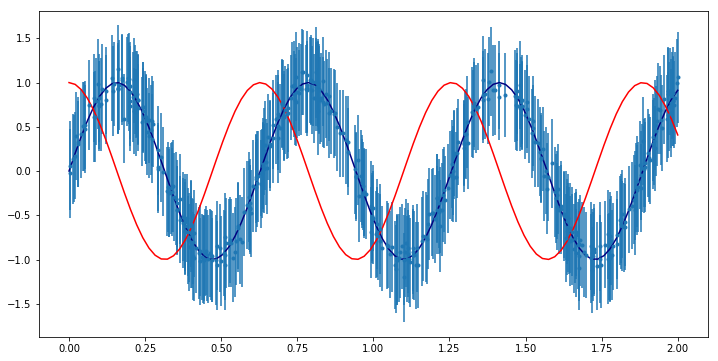

In [2]:
# data = np.genfromtxt('data/regression_1D.csv', delimiter=',')
# X = data[:, 0].reshape(-1, 1)
# Y = data[:, 1].reshape(-1, 1)

#HS: the workbook didn't come with the data file, so I made some random data
freq = 10
Xexact = np.linspace(0,2,100)
Yexact = np.sin(Xexact*freq)
dYdXexact = freq*np.cos(Xexact*freq)
X = np.sort(np.random.uniform(0,2,size=500))
Y = np.sin(X*freq)+ np.random.normal(0,0.1,len(X)) #+ np.exp(X/5)

#HS: add a sigma noise term
#sigma_n_Y = 0.1*np.ones(len(X))#
#sigma_n_Y = abs(np.random.normal(0,0.1,len(X)))

sigma_n_Y = np.random.normal(0.5,0.01,size=Y.shape)

plt.errorbar(X, Y,yerr=sigma_n_Y,fmt='.')
plt.plot(Xexact,Yexact,color='navy')
plt.plot(Xexact,dYdXexact/10,color='red')

In [3]:
X=X.reshape(-1,1)
Y=Y.reshape(-1,1)

We will consider the following probabilistic model:
$$ Y_i = f(X_i) + \varepsilon_i , $$
where $f \sim \mathcal{GP}(\mu(.), k(., .'))$, and $\varepsilon \sim \mathcal{N}(0, \tau^2 I)$.

Kernel 
--

Several kernels (i.e. covariance functions) are implemented in GPflow, and they can easily be combined to create new ones (see [advanced kernel notebook](../advanced/kernels.ipynb)). Implementing new covariance functions is also possible, as illustrated in the [kernel design notebook](../tailor/kernel_design.ipynb). Here, we will use a simple one:

HS: The original workbook sets the kernel here, however we're going to hold the definition until later so we can also set a prior on the kernel hyperparameters.

In [4]:
#k = gpflow.kernels.Matern52(input_dim=1)
#k = gpflow.kernels.RBF(input_dim=1)

The `input_dim` parameter is the dimension of the input space. It typically corresponds to the number of columns in `X`  (see the [advanced kernel notebook](../advanced/kernels.ipynb) for kernels defined on subspaces). A summary of the kernel can be obtained, either by `print(k)` (plain text) or

In [5]:
#k.as_pandas_table()

The Matern 5/2 kernel has two parameters: `lengthscales` encoding the "wiggliness" of the GP, and `variance` which tunes the amplitude. They are both set to 1.0 as the default value.  More details on the meaning of the other columns can be found in the [advanced kernel notebook](../advanced/kernels.ipynb).

Mean function (optional)
--
It is common to choose $\mu = 0$, which is the GPflow default. 

If there is a clear pattern (such as a mean value of `Y` that is far away from 0, or a linear trend in the data), mean functions can however be beneficial. Some simple ones are provided in the `gpflow.mean_functions` module. Here's how to define a linear mean function: ` meanf = gpflow.mean_functions.Linear()`.

In [6]:
meanf = gpflow.mean_functions.Linear()

Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Colocations handled automatically by placer.


Model construction
--

A GPflow model is created by instantiating one of the GPflow model classes, in this case GPR. We'll make a kernel `k` and instantiate a GPR object using the generated data and the kernel. We'll set the variance of the likelihood to a sensible initial guess, too. 

HS: The construction of the model has been modified from the original workbook to demonstrate how to set a prior on the kernel hyperparameters, and set heteroskedastic uncertainties. The prior in this example doesn't change the behaviour of the GPR.

In [7]:
#HS: This is where the uncertainties need to be entered. 
with gpflow.defer_build():
    k = gpflow.kernels.RBF(input_dim=1)
    
    # Kernel priors
    k.lengthscales.prior = gpflow.priors.Gaussian(1.,0.01)
    #k.lengthscales.prior = gpflow.priors.Uniform(lower=0.1,upper=1.0)
    
    # Uncertainties
    likelihood = gpflow.likelihoods.Gaussian(sigma_n_Y[:,None]**2)
    likelihood.variance.set_trainable(False)
    m = gpflow.models.GPR(X, Y, kern=k, mean_function=None)
    m.likelihood = likelihood
    m.compile()

In [8]:
#HS: Perform a parallel fit with a Matern52 kernel
with gpflow.defer_build():
    k_mat = gpflow.kernels.Matern52(input_dim=1,ARD=True)
    
    # Kernel priors
    k_mat.lengthscales.prior = gpflow.priors.Gaussian(1.,0.01)
    #k_mat.lengthscales.prior = gpflow.priors.Uniform(lower=0.1,upper=1.0)
    
    # Uncertainties
    likelihood_mat = gpflow.likelihoods.Gaussian(sigma_n_Y[:,None]**2)
    likelihood_mat.variance.set_trainable(False)
    m_mat = gpflow.models.GPR(X, Y, kern=k_mat, mean_function=None)
    m_mat.likelihood = likelihood_mat
    m_mat.compile()

A summary of the model can be obtained, either by `print(m)` (plain text) or 

In [9]:
m.as_pandas_table()

,class,prior,transform,trainable,shape,fixed_shape,value
GPR/kern/lengthscales,Parameter,"N(1.0,0.01)",+ve,True,(),True,1.0
GPR/kern/variance,Parameter,None,+ve,True,(),True,1.0
GPR/likelihood/variance,Parameter,None,+ve,False,"(500, 1)",True,"[[0.2508349761685217], [0.25546177425104316], ..."


In [10]:
m_mat.as_pandas_table()

,class,prior,transform,trainable,shape,fixed_shape,value
GPR/kern/lengthscales,Parameter,"N(1.0,0.01)",+ve,True,"(1,)",True,[1.0]
GPR/kern/variance,Parameter,None,+ve,True,(),True,1.0
GPR/likelihood/variance,Parameter,None,+ve,False,"(500, 1)",True,"[[0.2508349761685217], [0.25546177425104316], ..."


The first two lines correspond to the kernel parameters, and the third one gives the likelihood parameter (the noise variance $\tau^2$ in our model).

Those values can be accessed and set manually to sensible initial guesses, for instance:


Optimisation of the model parameters
--

In order to obtain meaningful predictions, we need to tune the model parameters (i.e. parameters of the kernel, likelihood and mean function if applicable) to the data at hand. 

There are several optimisers available in GPflow. Here we use the ScipyOptimizer which implements by default the L-BFGS-B algorithm (others can be selected using the `method=` keyword argument to `ScipyOptimizer`, for options see [the Scipy documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html)).

In [11]:
opt = gpflow.train.ScipyOptimizer()
opt.minimize(m)
m.as_pandas_table()

Instructions for updating:
Use tf.cast instead.


Instructions for updating:
Use tf.cast instead.


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 183.536129
  Number of iterations: 16
  Number of functions evaluations: 23


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 183.536129
  Number of iterations: 16
  Number of functions evaluations: 23


,class,prior,transform,trainable,shape,fixed_shape,value
GPR/kern/lengthscales,Parameter,"N(1.0,0.01)",+ve,True,(),True,0.3069465242142883
GPR/kern/variance,Parameter,None,+ve,True,(),True,13.888148515183032
GPR/likelihood/variance,Parameter,None,+ve,False,"(500, 1)",True,"[[0.2508349761685217], [0.25546177425104316], ..."


In [12]:
opt = gpflow.train.ScipyOptimizer()
opt.minimize(m_mat)
m_mat.as_pandas_table()

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 167.286532
  Number of iterations: 27
  Number of functions evaluations: 30


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 167.286532
  Number of iterations: 27
  Number of functions evaluations: 30


,class,prior,transform,trainable,shape,fixed_shape,value
GPR/kern/lengthscales,Parameter,"N(1.0,0.01)",+ve,True,"(1,)",True,[0.9261697806526534]
GPR/kern/variance,Parameter,None,+ve,True,(),True,162.54717965052325
GPR/likelihood/variance,Parameter,None,+ve,False,"(500, 1)",True,"[[0.2508349761685217], [0.25546177425104316], ..."


Notice how the value column has changed.

The local optimum found by Maximum Likelihood may not be the one you want, e.g. it may be overfitting or be oversmooth. This depends on the initial values of hyperparameters and is specific to each data set. As an alternative to Maximum Likelihood, MCMC is also available as shown in the [MCMC notebook](../advanced/mcmc.ipynb).

### HMC Fitting

In [13]:
#HS: Perform another fit with a Matern52 kernel and HMC
with gpflow.defer_build():
    k_mat_hmc = gpflow.kernels.Matern52(input_dim=1,ARD=False) #+ gpflow.kernels.Bias(input_dim=1)
    
    # Kernel priors
    k_mat_hmc.lengthscales.prior = gpflow.priors.Gaussian(1.,0.01)
    #k_mat.lengthscales.prior = gpflow.priors.Uniform(lower=0.1,upper=1.0)
    
    # Uncertainties
    likelihood_mat_hmc = gpflow.likelihoods.Gaussian(sigma_n_Y[:,None]**2)
    likelihood_mat_hmc.variance.set_trainable(False)
    m_mat_hmc = gpflow.models.GPMC(X, Y, kern=k_mat_hmc, 
                                   likelihood=likelihood_mat_hmc, mean_function=None)
    #m_mat_hmc.likelihood = likelihood_mat_hmc
    m_mat_hmc.compile()

In [14]:
m_mat_hmc.as_pandas_table()

,class,prior,transform,trainable,shape,fixed_shape,value
GPMC/V,Parameter,"N(0.0,1.0)",(none),True,"(500, 1)",True,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...."
GPMC/kern/lengthscales,Parameter,"N(1.0,0.01)",+ve,True,(),True,1.0
GPMC/kern/variance,Parameter,None,+ve,True,(),True,1.0
GPMC/likelihood/variance,Parameter,None,+ve,False,"(500, 1)",True,"[[0.2508349761685217], [0.25546177425104316], ..."


In [15]:
o = gpflow.train.AdamOptimizer(0.01)
o.minimize(m_mat_hmc, maxiter=15) # start near MAP

In [16]:
s = gpflow.train.HMC()
samples = s.sample(m_mat_hmc, 100, epsilon=0.02, lmax=20, lmin=5, thin=5, logprobs=False)#, verbose=True)

KeyboardInterrupt: 

In [ ]:
samples.shape

In [ ]:
samples['GPMC']

In [ ]:
samples['GPMC/kern/Matern52/variance'].hist(bins=20)

In [ ]:
m_mat_hmc.as_pandas_table()



### Prediction

We can now use the model to make some predictions at new locations `Xnew`. One may be interested in predicting two different quantities: the latent function values `f(Xnew)` (the denoised signal), or the values of new observations `y(Xnew)` (signal + noise). Since we are dealing with Gaussian probabilistic models, the predictions typically output a mean and variance. Alternatively, one can obtain samples of `f(Xnew)` or log-density of new data points `(Xnew, Ynew)`.

GPflow models have several prediction methods:

 - `m.predict_f` returns the mean and variance of $f$ at the points `Xnew`. 

 - `m.predict_f_full_cov` additionally returns the full covariance matrix of $f$ at the points `Xnew`.

 - `m.predict_f_samples` returns samples of the latent function.

 - `m.predict_y` returns the mean and variance of a new data point (i.e. includes the noise variance).

 - `m.predict_density` returns the log-density of the observations `Ynew` at `Xnew`.
 
We use `predict_f` and `predict_f_samples` to plot 95% confidence intervals and samples from the posterior distribution. 

In [ ]:
## generate test points for prediction
Xstar_points_1D = np.linspace(0,2.0,120).reshape(-1,1,)

## predict mean and variance of latent GP at test points
mean, var = m.predict_f(Xstar_points_1D)
mean_mat, var_mat = m_mat.predict_f(Xstar_points_1D)
mean_mat_hmc, var_mat_hmc = m_mat_hmc.predict_f(Xstar_points_1D)

## generate 10 samples from posterior
samples = m.predict_f_samples(Xstar_points_1D, 10)  # shape (10, 100, 1)

## plot 
plt.figure(figsize=(16, 8))
plt.errorbar(X, Y, yerr=sigma_n_Y,fmt='.', alpha=0.3)
plt.plot(Xstar_points_1D, mean, 'C0', lw=5, color='orange')
plt.plot(Xstar_points_1D, mean_mat, 'C0', lw=3, color='g')
#plt.plot(Xstar_points_1D, mean_mat_hmc, 'C0', lw=3, color='m')
[plt.plot(Xstar_points_1D, sample, 'C0', lw=1, color='m') for sample in samples]

plt.fill_between(Xstar_points_1D[:,0],
                 mean[:,0] - 1.96 * np.sqrt(var[:,0]),
                 mean[:,0] + 1.96 * np.sqrt(var[:,0]),
                 color='orange', alpha=0.2)

plt.fill_between(Xstar_points_1D[:,0],
                 mean_mat[:,0] - 1.96 * np.sqrt(var_mat[:,0]),
                 mean_mat[:,0] + 1.96 * np.sqrt(var_mat[:,0]),
                 color='g', alpha=0.2)

#plt.plot(Xstar_points_1D, samples[:, :, 0].T, 'C0', linewidth=.5)
plt.xlim(0,2.1);


Derivative of the latent function $f(x)$
--
HS: This is derived from 'Differentiating Gaussian Processes' by Andrew McHutchon, with inspiration from Larry Widrow's GPy implementation of this. Note that this only works for RBF kernels, and only for one kernel per dimension. In development: Matern 3/2 kernel derivatives.

In [ ]:
def dfdx_calc_RBF(session, mod, xstar_list):
    with session.as_default():
        variances = mod.likelihood.read_values()['GPR/likelihood/variance']
        KXX = mod.kern.K(mod.X.value, mod.X.value,).eval() + np.diag(variances.reshape(-1)) #N x N
        if np.linalg.det(KXX)==0.0:
            print('WARNING: KXX (close to) singular')
        KXXinv = np.linalg.inv(KXX)#N x N
        alpha = np.dot(KXXinv, mod.Y.value) #N x 1
        
        #Extract lengthscales
        lengthscales = np.array([mod.read_trainables()[key] for key in list(mod.read_trainables().keys())\
                        if 'lengthscales' in key]).reshape(-1)
        
        InvLambda = np.diag(1/(lengthscales**2)) #DxD
        Xtilde = np.array([xstar_list[ii] - mod.X.value for ii in range(len(xstar_list))])
        KXx = mod.kern.K(mod.X.value, xstar_list).eval().T         
        mean_dfdx_list = [-np.linalg.multi_dot([InvLambda, Xtilde[ii].T, 
                        np.multiply(KXx[ii].reshape(-1,1), alpha)]) for ii in range(len(xstar_list))]
        
        #Variance
        kernel_variances = np.diag(np.array([mod.read_trainables()[key] for key in list(mod.read_trainables().keys())\
                        if 'variance' in key and 'kern' in key]).reshape(-1))
        
        ddkxx = InvLambda * kernel_variances #D x D 
                #SHOULD THERE BE A MINUS SIGN ABOVE?
        dkXx = [np.multiply(KXx[ii].reshape(-1,1), np.dot(Xtilde[ii], InvLambda)) \
                for ii in range(len(xstar_list))] #N x D
        covar_dfdx_list = [ddkxx - np.linalg.multi_dot([dkXx[ii].T, KXXinv, dkXx[ii]])\
                                                    for ii in range(len(xstar_list))] # D x D 
        
    return np.array(mean_dfdx_list), np.array(covar_dfdx_list)

In [ ]:
def dfdx_calc_Matern52(session, mod, xstar_list):
    with session.as_default():
        # M test points
        # N data points
        # D dimensions
        like_variances = mod.likelihood.read_values()['GPR/likelihood/variance']
        KXX = mod.kern.K(mod.X.value, mod.X.value,).eval() + np.diag(like_variances.reshape(-1)) #N x N
        if np.linalg.det(KXX)==0.0:
            print("WARNING: KXX (close to) singular.")

        KXXinv = np.linalg.inv(KXX) #N x N
        Lcho_KXX = np.linalg.cholesky(KXX)
        Lcho_inv_KXX = np.linalg.inv(Lcho_KXX)
        KXXinv_cho = np.matmul(Lcho_inv_KXX.T, Lcho_inv_KXX)
        KXXinv = KXXinv_cho
        
        alpha = np.dot(KXXinv, mod.Y.value) #N x 1
       
        # Extract lengthscales
        lengthscales = np.array([mod.read_trainables()[key] for key in list(mod.read_trainables().keys())\
                        if 'lengthscales' in key]).reshape(-1)
        InvLambda = np.diag(1/(lengthscales**2)) #DxD
        #InvLambda = np.diag(1/(lengthscales)) #DxD
        
        # Extract Kernel Variances
        kernel_variances = np.diag(np.array([mod.read_trainables()[key] for key in list(mod.read_trainables().keys())\
                        if 'variance' in key and 'kern' in key]).reshape(-1))
        
        # Xtilde calculation
        Xtilde = np.array([xstar_list[ii] - mod.X.value for ii in range(len(xstar_list))]) #MxNxD
        
        # R_Lambda Calculation MxN
        R_Lambda = np.zeros([Xtilde.shape[0],Xtilde.shape[1]]) #MxN
        for ii in range(Xtilde.shape[0]):
            for jj in range(Xtilde.shape[1]):
                R_Lambda[ii,jj] = np.sqrt(np.linalg.multi_dot([Xtilde[ii,jj].reshape(-1,1).T,InvLambda,
                                                       Xtilde[ii,jj].reshape(-1,1)]))
        
        # dk(x,X)/dx calculation DxN
        dkxX_dx = np.array([kernel_variances\
                    *(-(5/3) * np.matmul(InvLambda,Xtilde[ii].T)\
                              *(np.exp(-np.sqrt(5) * R_Lambda[ii])).reshape(-1,1).T\
                      -(5*np.sqrt(5)/3) * np.matmul(InvLambda,Xtilde[ii].T) \
                              *R_Lambda[ii]*(np.exp(-np.sqrt(5) * R_Lambda[ii])).reshape(-1,1).T\
                     ) for ii in range(Xtilde.shape[0])])
        
        # Mean df/dx calculation
        mean_dfdx_list = [np.dot(dkxX_dx[ii],alpha) for ii in range(Xtilde.shape[0])]
        
        # Variance df/dx calculation
        covar_dfdx_list = [(5/3) * kernel_variances * InvLambda \
                           - np.linalg.multi_dot([dkxX_dx[ii], KXXinv, dkxX_dx[ii].T])\
                        for ii in range(Xtilde.shape[0])]
        
    return np.array(mean_dfdx_list), np.array(covar_dfdx_list)

In [ ]:
#xstar = np.linspace(0,2.0,120).reshape(-1,1,)

In [ ]:
dfdx, var_dfdx = dfdx_calc_RBF(gpflow.get_default_session(), m, Xstar_points_1D)

In [ ]:
dfdx_mat, var_dfdx_mat = dfdx_calc_Matern52(gpflow.get_default_session(), m_mat, Xstar_points_1D)

In [ ]:
## plot 
plt.figure(figsize=(16, 8))
plt.errorbar(X, Y, yerr=sigma_n_Y,fmt='.', alpha=0.3)
plt.plot(Xstar_points_1D, mean, 'C0', lw=3, color='b')
plt.fill_between(Xstar_points_1D[:,0],
                 mean[:,0] - 1.96 * np.sqrt(var[:,0]),
                 mean[:,0] + 1.96 * np.sqrt(var[:,0]),
                 color='C0', alpha=0.2)

plt.plot(Xstar_points_1D, mean, 'C0', lw=3, color='b')
plt.plot(Xstar_points_1D, mean_mat, 'C0', lw=3, color='g')

#Divide derivatives by 5 to make the plot more compact
plt.errorbar(Xstar_points_1D.reshape(-1), dfdx_mat.reshape(-1)/5, yerr=(var_dfdx_mat.reshape(-1))/5, color='g')
plt.errorbar(Xstar_points_1D.reshape(-1), dfdx.reshape(-1)/5, yerr=np.sqrt(var_dfdx.reshape(-1))/5)
plt.plot(Xexact, dYdXexact/5, color='r')

plt.axhline(0)

plt.xlim(-0.1, 2.1);

GP regression in higher dimension
--

Very little changes when the input space has more than one dimension. `X` is a numpy array with one column per dimension. The kernel may be set with `input_dim` equal to the number of columns of `X`, and setting the parameter `ARD=True` allows tuning a different lengthscale per dimension, which is generally recommended.

HS: I have a rough 2D example which I'll add to this workbook tomorrow.

Further reading
--

Several notebooks are available to go into more details:

  - [Sparse GP regression for big data](../advanced/gps_for_big_data.ipynb) when there is a large number of observations,
  - [ordinal regression](../advanced/ordinal_regression.ipynb) if the data is ordinal,
  - [multi-outputs and coregionalisation](../advanced/coregionalisation.ipynb) if `Y` is multidimensional.

2D GP Regression Example
--
HS: This is an example of 2D GPR I pulled from http://www-users.york.ac.uk/~dp626/shared/GPflow_multiinput_example.html and then altered to include heteroskedastic uncertainties. This is just the basic fit, there's more on the original example.


In [ ]:
#Exact Input and Output Grids
freq1 = 2.0
freq2 = 6.0

X1_edges_exact = np.linspace(-1,1,101)
X2_edges_exact = np.linspace(-1,1,101)
X1_cents_exact = (X1_edges_exact[1:] - X1_edges_exact[:-1])/2 + X1_edges_exact[:-1]
X2_cents_exact = (X2_edges_exact[1:] - X2_edges_exact[:-1])/2 + X2_edges_exact[:-1]

X1_edges_mesh_exact, X2_edges_mesh_exact = np.meshgrid(X1_edges_exact, X2_edges_exact, indexing='ij')
X1_cents_mesh_exact, X2_cents_mesh_exact = np.meshgrid(X1_cents_exact, X2_cents_exact, indexing='ij')


Y_mesh_exact = np.cos(freq1*X1_cents_mesh_exact) + np.cos(freq2*X2_cents_mesh_exact)
dYdX1_mesh_exact = -freq1 * np.sin(freq1*X1_cents_mesh_exact) 
dYdX2_mesh_exact = -freq2 * np.sin(freq2*X2_cents_mesh_exact)

In [ ]:
#Sample Input and Output Grids
Nsamps = 1000
X_sample = np.random.uniform(-1.,1.,(Nsamps,2))
Y_sample = (np.cos(freq1*X_sample[:,0]) \
            + np.cos(freq2*X_sample[:,1]) \
            + np.random.normal(0,0.01,size=X_sample.shape[0])).reshape(-1,1)

#Uncertainties:
Y_sample_sigma = 0.01*np.random.random(size=Y_sample.shape)

In [ ]:
# fig2d, ax2d = plt.subplots(ncols=1, nrows=6, gridspec_kw={"height_ratios":[15,1,15,1,15,1]})
# fig2d.set_figheight(18)
# fig2d.set_figwidth(6)

# ax_im = ax2d[0]
# ax_cbar = ax2d[1]

# ax_dYdX1 = ax2d[2]
# ax_dYdX1_cbar = ax2d[3]

# ax_dYdX2 = ax2d[4]
# ax_dYdX2_cbar = ax2d[5]


# ax_im.set_aspect('equal')
# ax_dYdX1.set_aspect('equal')
# ax_dYdX2.set_aspect('equal')

# im_Y_exact= ax_im.pcolormesh(X1_edges_mesh_exact, X2_edges_mesh_exact, 
#                              Y_mesh_exact, cmap='magma')
# im_Y_dYdX1= ax_dYdX1.pcolormesh(X1_edges_mesh_exact, X2_edges_mesh_exact, 
#                                 dYdX1_mesh_exact, cmap='seismic')
# im_Y_dYdX2= ax_dYdX2.pcolormesh(X1_edges_mesh_exact, X2_edges_mesh_exact, 
#                                 dYdX2_mesh_exact, cmap='seismic')

# ax_im.scatter(X_sample[:,0], X_sample[:,1])

# cb_exact = fig2d.colorbar(im_Y_exact, cax=ax_cbar,orientation='horizontal')
# cb_dYdX1 = fig2d.colorbar(im_Y_dYdX1, cax=ax_dYdX1_cbar,orientation='horizontal')
# cb_dYdX2 = fig2d.colorbar(im_Y_dYdX2, cax=ax_dYdX2_cbar,orientation='horizontal')
# ax_im.set_xlim(-1,1)
# ax_im.set_ylim(-1,1)
# plt.show()

For a 2D fit we need a 2D kernel. We can either set the use an RBF kernel with dimension 2:
```python
k2d = gpflow.kernels.RBF(input_dim=2, ARD=True)
```
or stick two RBF kernels together for the equivalent:
```python
k2d = gpflow.kernels.RBF(input_dim=1, active_dims=[0], ARD=False)*
        gpflow.kernels.RBF(input_dim=1, active_dims=[1], ARD=False)
```
or use two different kernels, like a Matern and a RBF, which I've found is useful when you're mixing linear and angular coordinates (e.g. R and phi in cylindrical coordinates):
```python
k2d = gpflow.kernels.RBF(input_dim=1, active_dims=[0], ARD=False)*
        gpflow.kernels.Matern(input_dim=1, active_dims=[1], ARD=False)
```
In the following model we're also going to set a prior on one of the lengthscales. 

In [ ]:
with gpflow.defer_build():
    # define kernel    
    #k2d = gpflow.kernels.RBF(input_dim=1, active_dims=[0], ARD=False)*\
     #       gpflow.kernels.RBF(input_dim=1, active_dims=[1], ARD=False)
    k2d = gpflow.kernels.RBF(input_dim=2, ARD=True)
    
    # Kernel priors
    #k2d.kernels.lengthscales.prior = gpflow.priors.Gaussian(1,0.1)
    
    likelihood = gpflow.likelihoods.Gaussian(Y_sample_sigma**2)
    likelihood.variance.set_trainable(False)
    m2d = gpflow.models.GPR(X_sample, Y_sample, kern=k2d, mean_function=None)
    m2d.likelihood = likelihood
    m2d.compile()
    
m2d.as_pandas_table()

In [ ]:
with gpflow.defer_build():
    # define kernel    
#     k2d_mat = gpflow.kernels.RBF(input_dim=1, active_dims=[0], ARD=False)*\
#             gpflow.kernels.RBF(input_dim=1, active_dims=[1], ARD=False)
    #k2d_mat = gpflow.kernels.Matern52(input_dim=2, ARD=True)
    k2d_mat = gpflow.kernels.Matern52(input_dim=1, active_dims=[0], ARD=False)*\
            gpflow.kernels.Matern52(input_dim=1, active_dims=[1], ARD=False)
    
    # Kernel priors
    #k2d_mat.kernels[1].lengthscales.prior = gpflow.priors.Gaussian(1,0.1)
    
    likelihood_mat = gpflow.likelihoods.Gaussian(Y_sample_sigma**2)
    likelihood_mat.variance.set_trainable(False)
    m2d_mat = gpflow.models.GPR(X_sample, Y_sample, kern=k2d_mat, mean_function=None)
    m2d_mat.likelihood = likelihood_mat
    m2d_mat.compile()
    
m2d_mat.as_pandas_table()

In [ ]:
#Train the GP 
opt = gpflow.train.ScipyOptimizer()
opt.minimize(m2d)
m2d.as_pandas_table()

In [ ]:
#Train the GP 
opt = gpflow.train.ScipyOptimizer()
opt.minimize(m2d_mat)
m2d_mat.as_pandas_table()

In [ ]:
m2d.read_trainables()

In [ ]:
m2d_mat.read_trainables()

In [ ]:
#Define a new X grid over which to interpolate - XSTAR_grid
X1_edges_star = np.linspace(-1,1,200)
X2_edges_star = np.linspace(-1,1,200)
X1_cents_star = (X1_edges_star[1:] - X1_edges_star[:-1])/2 + X1_edges_star[:-1]
X2_cents_star = (X2_edges_star[1:] - X2_edges_star[:-1])/2 + X2_edges_star[:-1]

X1_edges_mesh_star, X2_edges_mesh_star = np.meshgrid(X1_edges_star, X2_edges_star, indexing='ij')
X1_cents_mesh_star, X2_cents_mesh_star = np.meshgrid(X1_cents_star, X2_cents_star, indexing='ij')

Xstar_points_2D = np.vstack([X1_cents_mesh_star.ravel(), X2_cents_mesh_star.ravel()]).T

In [ ]:
fmean_list, fvar_list = m2d.predict_f(Xstar_points_2D)
fmean_mesh = fmean_list.reshape(X1_cents_mesh_star.shape)

fmean_list_mat, fvar_list_mat = m2d_mat.predict_f(Xstar_points_2D)
fmean_mesh_mat = fmean_list_mat.reshape(X1_cents_mesh_star.shape)

In [ ]:
mean_dfdx, covar_dfdx = dfdx_calc_RBF(gpflow.get_default_session(), m2d, Xstar_points_2D)

In [ ]:
mean_dfdx_mat, covar_dfdx_mat = dfdx_calc_Matern52(gpflow.get_default_session(), m2d_mat, Xstar_points_2D)

In [ ]:
mean_dfdX1_mesh = mean_dfdx[:,0].reshape(-1).reshape(X1_cents_mesh_star.shape)
mean_dfdX2_mesh = mean_dfdx[:,1].reshape(-1).reshape(X1_cents_mesh_star.shape)

mean_dfdX1_mesh_mat = mean_dfdx_mat[:,0].reshape(-1).reshape(X1_cents_mesh_star.shape)
mean_dfdX2_mesh_mat = mean_dfdx_mat[:,1].reshape(-1).reshape(X1_cents_mesh_star.shape)

In [ ]:
fig2d, ax2d = plt.subplots(ncols=3, nrows=6, gridspec_kw={"height_ratios":[15,1,15,1,15,1]})
fig2d.set_figheight(24)
fig2d.set_figwidth(16)

ax_im_exact = ax2d[0,0]
ax_cbar_exact = ax2d[1,0]
ax_dYdX1_exact = ax2d[2,0]
ax_dYdX1_exact_cbar = ax2d[3,0]
ax_dYdX2_exact = ax2d[4,0]
ax_dYdX2_exact_cbar = ax2d[5,0]

ax_im_star = ax2d[0,1]
ax_cbar_star = ax2d[1,1]
ax_dYdX1_star = ax2d[2,1]
ax_dYdX1_star_cbar = ax2d[3,1]
ax_dYdX2_star = ax2d[4,1]
ax_dYdX2_star_cbar = ax2d[5,1]

ax_im_star_mat = ax2d[0,2]
ax_cbar_star_mat = ax2d[1,2]
ax_dYdX1_star_mat = ax2d[2,2]
ax_dYdX1_star_cbar_mat = ax2d[3,2]
ax_dYdX2_star_mat = ax2d[4,2]
ax_dYdX2_star_cbar_mat = ax2d[5,2]


ax_im_exact.set_aspect('equal')
ax_dYdX1_exact.set_aspect('equal')
ax_dYdX2_exact.set_aspect('equal')

ax_im_star.set_aspect('equal')
ax_dYdX1_star.set_aspect('equal')
ax_dYdX2_star.set_aspect('equal')

ax_im_star_mat.set_aspect('equal')
ax_dYdX1_star_mat.set_aspect('equal')
ax_dYdX2_star_mat.set_aspect('equal')

fmean_maxmin = np.amax(abs(np.concatenate([Y_mesh_exact.flatten(), 
                                            fmean_mesh.flatten(), 
                                            fmean_mesh_mat.flatten()])))
mean_dfdX1_maxmin = np.amax(abs(np.concatenate([dYdX1_mesh_exact.flatten(), 
                                                 mean_dfdX1_mesh.flatten(), 
                                                 mean_dfdX1_mesh_mat.flatten()]))) 
mean_dfdX2_maxmin = np.amax(abs(np.concatenate([dYdX2_mesh_exact.flatten(), 
                                                 mean_dfdX2_mesh.flatten(), 
                                                 mean_dfdX2_mesh_mat.flatten()])))


im_Y_exact= ax_im_exact.pcolormesh(X1_edges_mesh_exact, X2_edges_mesh_exact, Y_mesh_exact, cmap='magma',
                                  vmin = -fmean_maxmin, vmax=fmean_maxmin)
im_Y_dYdX1_exact= ax_dYdX1_exact.pcolormesh(X1_edges_mesh_exact, X2_edges_mesh_exact, dYdX1_mesh_exact, cmap='seismic',
                                  vmin = -mean_dfdX1_maxmin, vmax=mean_dfdX1_maxmin)
im_Y_dYdX2_exact= ax_dYdX2_exact.pcolormesh(X1_edges_mesh_exact, X2_edges_mesh_exact, dYdX2_mesh_exact, cmap='seismic',
                                  vmin = -mean_dfdX2_maxmin, vmax=mean_dfdX2_maxmin)

im_Y_star = ax_im_star.pcolormesh(X1_edges_mesh_star, X2_edges_mesh_star, fmean_mesh, cmap='magma',
                                  vmin = -fmean_maxmin, vmax=fmean_maxmin)
im_Y_dYdX1_star = ax_dYdX1_star.pcolormesh(X1_edges_mesh_star, X2_edges_mesh_star, mean_dfdX1_mesh, cmap='seismic',
                                  vmin = -mean_dfdX1_maxmin, vmax=mean_dfdX1_maxmin)
im_Y_dYdX2_star = ax_dYdX2_star.pcolormesh(X1_edges_mesh_star, X2_edges_mesh_star, mean_dfdX2_mesh, cmap='seismic',
                                  vmin = -mean_dfdX2_maxmin, vmax=mean_dfdX2_maxmin)

im_Y_star_mat = ax_im_star_mat.pcolormesh(X1_edges_mesh_star, X2_edges_mesh_star, fmean_mesh_mat, cmap='magma',
                                  vmin = -fmean_maxmin, vmax=fmean_maxmin)
im_Y_dYdX1_star_mat = ax_dYdX1_star_mat.pcolormesh(X1_edges_mesh_star, X2_edges_mesh_star, 
                                                   mean_dfdX1_mesh_mat, cmap='seismic',
                                  vmin = -mean_dfdX1_maxmin, vmax=mean_dfdX1_maxmin)
im_Y_dYdX2_star_mat = ax_dYdX2_star_mat.pcolormesh(X1_edges_mesh_star, X2_edges_mesh_star, 
                                                   mean_dfdX2_mesh_mat, cmap='seismic',
                                  vmin = -mean_dfdX2_maxmin, vmax=mean_dfdX2_maxmin)

ax_im_exact.scatter(X_sample[:,0], X_sample[:,1],s=2)
ax_im_star.scatter(X_sample[:,0], X_sample[:,1],s=2)
ax_im_star_mat.scatter(X_sample[:,0], X_sample[:,1],s=2)

ax_im_exact.set_title('Exact function and derivatives')
ax_im_star.set_title('Reconstructed function and derivatives')
ax_im_star_mat.set_title('Reconstructed function and derivatives, Matern 5/2')

cb_exact = fig2d.colorbar(im_Y_exact, cax=ax_cbar_exact,orientation='horizontal')
cb_dYdX1_exact = fig2d.colorbar(im_Y_dYdX1_exact, cax=ax_dYdX1_exact_cbar,orientation='horizontal')
cb_dYdX2_exact = fig2d.colorbar(im_Y_dYdX2_exact, cax=ax_dYdX2_exact_cbar,orientation='horizontal')

cb_star = fig2d.colorbar(im_Y_star, cax=ax_cbar_star,orientation='horizontal')
cb_dYdX1_star = fig2d.colorbar(im_Y_dYdX1_star, cax=ax_dYdX1_star_cbar,orientation='horizontal')
cb_dYdX2_star = fig2d.colorbar(im_Y_dYdX2_star, cax=ax_dYdX2_star_cbar,orientation='horizontal')

cb_star_mat = fig2d.colorbar(im_Y_star_mat, cax=ax_cbar_star_mat,orientation='horizontal')
cb_dYdX1_star_mat = fig2d.colorbar(im_Y_dYdX1_star_mat, cax=ax_dYdX1_star_cbar_mat,orientation='horizontal')
cb_dYdX2_star_mat = fig2d.colorbar(im_Y_dYdX2_star_mat, cax=ax_dYdX2_star_cbar_mat,orientation='horizontal')

ax_im_exact.set_xlim(-1,1)
ax_im_exact.set_ylim(-1,1)
ax_im_star.set_xlim(-1,1)
ax_im_star.set_ylim(-1,1)
ax_im_star_mat.set_xlim(-1,1)
ax_im_star_mat.set_ylim(-1,1)
plt.show()